In [1]:
import os
from PIL import Image
import numpy as np
import pandas

from utils import transform

import matplotlib.pyplot as plt

In [2]:
img_dir = '/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/images'
transf = transform
size = (400,400)
width = None
height = None
annotations_dir = '/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/labels'
idx = 0

In [3]:
# Image ---------------------------------------------------
img_path = os.path.join(img_dir,f'{idx}.png')
image = Image.open(img_path).resize(size)
image = transf(image)

width = image.shape[1]
height = image.shape[2] 

dW = width//7
dH = height//7


# Output ---------------------------------------------------
print(image.shape)

torch.Size([1, 400, 400])


In [4]:
# Boxes ---------------------------------------------------

# read the data ---> xmin, xmax, ymin, ymax, label
labels_path = os.path.join(annotations_dir,f'{idx}.csv')
df = pandas.read_csv(labels_path)
label, xmin, xmax, ymin, ymax = df['label'].to_numpy(), df['xmin'].to_numpy(), df['xmax'].to_numpy(), df['ymin'].to_numpy(), df['ymax'].to_numpy()

# compute factor converstion in widht and heigth ---> factor_hor, factor_ver
factor_hor, factor_ver = width/300, height/300

# compute the new values of bbox ---> xmin, xmax, ymin, ymax
xmax, xmin, ymax, ymin = xmax*factor_hor,xmin*factor_hor, ymax*factor_ver, ymin*factor_ver

# comput he center ---> cx, cy
cx, cy = (xmin + xmax)//2, (ymin + ymax)//2

# compute the normalized versions ---> px,py,pw,ph
px, py = (cx % dW)/dW, (cy % dH)/dH
ph, pw = (xmax - xmin)/width, (ymax - ymin)/height

boxes = np.stack(
            (px,py,ph,pw),
            axis= 1
        )


# Output -------------------------------------------------
print(labels_path)
print(width)
print(boxes)

/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/labels/0.csv
400
[[0.8245614  0.94736842 0.07       0.05666667]
 [0.52631579 0.07017544 0.13666667 0.16666667]
 [0.75438596 0.1754386  0.08666667 0.11333333]
 [0.71929825 0.31578947 0.1        0.14      ]
 [0.66666667 0.29824561 0.12666667 0.20666667]
 [0.28070175 0.87719298 0.08       0.09333333]
 [0.63157895 0.33333333 0.03333333 0.05333333]
 [0.92982456 0.63157895 0.09666667 0.11666667]
 [0.40350877 0.94736842 0.20333333 0.16333333]
 [0.0877193  0.75438596 0.09666667 0.15333333]
 [0.         0.07017544 0.11       0.17666667]
 [0.89473684 0.36842105 0.08333333 0.08333333]
 [0.22807018 0.64912281 0.09666667 0.08666667]
 [0.96491228 0.8245614  0.04666667 0.05333333]
 [0.43859649 0.10526316 0.11666667 0.12666667]
 [0.26315789 0.33333333 0.22       0.22      ]
 [0.29824561 0.56140351 0.12       0.18333333]]


In [5]:
# Label -----------------------------------------------------
n_objects = cx.shape[0]
n_classes = 10

class_prob = np.zeros((n_objects, n_classes))
class_prob[np.arange(n_objects), label] = 1

target = np.concatenate((boxes, class_prob), axis=1)        # target[i] = [px,py,pw,ph,0,0,0,0,1,0,0,0,0]

# output ----------------------------------------------------

print('bbox:',target[0,0:4])
print('prob:',target[0,4:14])

bbox: [0.8245614  0.94736842 0.07       0.05666667]
prob: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
"""
target[i] = [px,py,pw,ph,0,0,0,0,1,0,0,0,0]

[ box1 | box1 | box1 | box1 ]       [ 0 | 0 | 0 | 0 ]
[ box1 | box1 | box1 | box1 ]       [ 0 | 0 | 0 | 0 ]
[ box1 | box1 | box1 | box1 ]   *   [ 0 | 1 | 0 | 0 ]
[ box1 | box1 | box1 | box1 ]       [ 0 | 0 | 0 | 0 ]

box1 * one_vec1 + box2 * one_vec2 + box3 * one_vec3 ...
# Condicion:
1. Dos objetos no pueden esar en una misma celda
"""

'\ntarget[i] = [px,py,pw,ph,0,0,0,0,1,0,0,0,0]\n\n[ box1 | box1 | box1 | box1 ]       [ 0 | 0 | 0 | 0 ]\n[ box1 | box1 | box1 | box1 ]       [ 0 | 0 | 0 | 0 ]\n[ box1 | box1 | box1 | box1 ]   *   [ 0 | 1 | 0 | 0 ]\n[ box1 | box1 | box1 | box1 ]       [ 0 | 0 | 0 | 0 ]\n\nbox1 * one_vec1 + box2 * one_vec2 + box3 * one_vec3 ...\n# Condicion:\n1. Dos objetos no pueden esar en una misma celda\n'

In [7]:

cell_i = np.uint8(cx//dW)
cell_j = np.uint8(cy//dH)

cell_position = np.zeros([n_objects,7,7,14])
cell_position[np.arange(n_objects),cell_i,cell_j,:] = 1

cell_position_sum = cell_position.sum(axis=0)
i_x, i_y = np.where(cell_position_sum[...,0] > 1)

k_idx = []
for ix, iy in zip(i_x, i_y):
    k = np.where(cell_i == ix, 1, 0) * np.where(cell_j == iy, 1, 0)
    k_idx.append(np.where(k == 1)[0])


if ~(len(k_idx) == 0):
    print(k_idx)
        
    vect_ = np.ones_like(target)
    for boxes in k_idx:
        areas = []

        for box in boxes:
            wn, hn = target[box,2:4]
            areas.append(wn*hn)

        max_index = np.argmax(np.array(areas))
        
        for k,box in enumerate(boxes):
            if k == max_index:
                continue
            vect_ [box,:] = 0


    target_corrected = target*vect_
    cell_position_corrected = cell_position * vect_[:,None,None,:]

    target_corrected = target_corrected[:,None,None,:] * cell_position_corrected
    target_corrected = target_corrected.sum(axis=0)

    cell_position_corrected_sum = cell_position_corrected.sum(axis=0)

    obj_position_ = cell_position_corrected_sum[...,0]
    target_ = target_corrected


assert target_.shape == (7,7,14)
assert obj_position_.shape == (7,7)

[array([ 6, 13]), array([ 7, 12]), array([ 8, 10, 11]), array([ 2, 16])]


In [8]:
"""
| box | p_class | background | object_prescense| 
| (4) |   (10)  |     (1)    |         (1)     |
"""

no_obj_position = 1 - obj_position_
no_obj_position = no_obj_position[...][...,None]

target_out = np.concatenate((target_, no_obj_position), axis=2)
target_out = np.concatenate((target_out, obj_position_[...][...,None]), axis=2)

print(target_out.shape)

(7, 7, 16)


In [42]:
print(target_out[:,3])

[[0.71929825 0.31578947 0.1        0.14       0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.92982456 0.63157895 0.09666667 0.11666667 0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.29824561 0.56140351 0.12       0.18333333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.         0.         1.        

In [44]:
for x in range(7):
    for y in range(7):
        if target_out[x,y,-1] == 1.0:
            print("------------------------------------------")
            print(x,y)
            print("Object bounding box:",target_out[x,y,0:4])
            print("Class probability:",target_out[x,y,4:15])
            print("Object presensce:",target_out[x,y,15:16])

------------------------------------------
0 3
Object bounding box: [0.71929825 0.31578947 0.1        0.14      ]
Class probability: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Object presensce: [1.]
------------------------------------------
1 0
Object bounding box: [0.8245614  0.94736842 0.07       0.05666667]
Class probability: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Object presensce: [1.]
------------------------------------------
1 1
Object bounding box: [0.96491228 0.8245614  0.04666667 0.05333333]
Class probability: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Object presensce: [1.]
------------------------------------------
1 5
Object bounding box: [0.26315789 0.33333333 0.22       0.22      ]
Class probability: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Object presensce: [1.]
------------------------------------------
2 0
Object bounding box: [0.28070175 0.87719298 0.08       0.09333333]
Class probability: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Object presensce: [1.]
------------------------------------------
2 

# Dataloader tests

In [1]:
import torch
import gc
from dataloader import CustomImageDataset, DataLoader
from torchvision.transforms import Compose
import torchvision.transforms as transforms
from utils import transform

dataset = CustomImageDataset(annotations_dir = '/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/labels',
                             img_dir = '/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/images',
                             data_transform = transform,
                             size=(448,448))

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


def clean_gpu():
    for i in range(10):    
        torch.cuda.empty_cache()
        gc.collect()

device = torch.device('cpu')

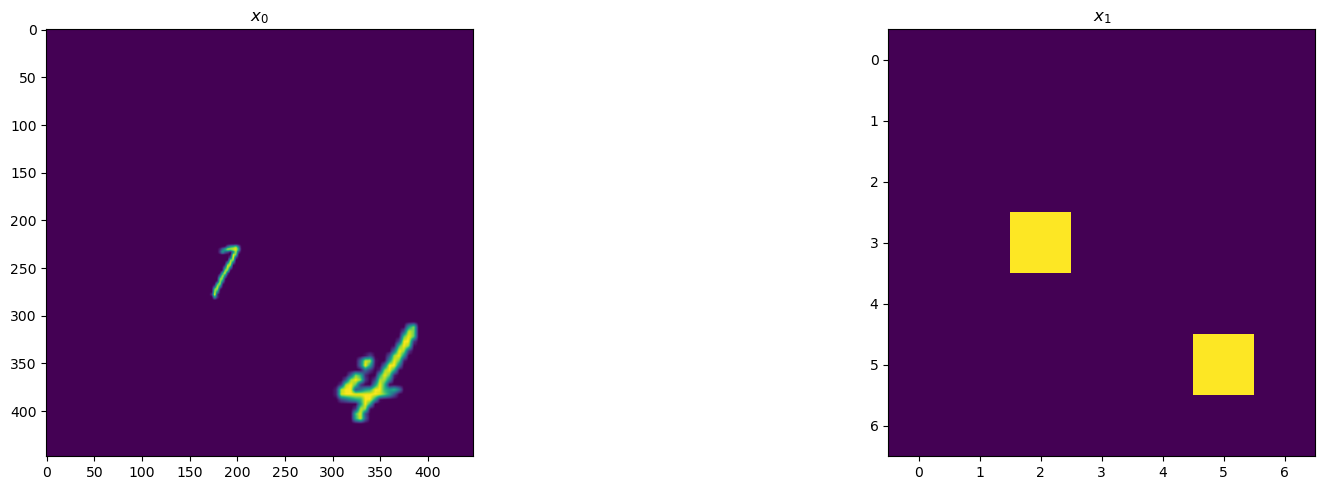

In [21]:
import matplotlib.pyplot as plt
from utils import plot_images, clean_gpu

n_break = 0
# model.eval()

for idx, data in enumerate(train_loader):

    # get the inputs
    img, target = data
    img, target = img.to(device), target['one_obj'].to(device)

    # forward
    # prediction = model(img)
    # predict_confidence = torch.sigmoid(prediction[...,0])
    target_confidence = target.squeeze()

    img2show = img.detach()[0,...].cpu()
    target2show = target_confidence.detach()[0,...].cpu()
    # predict2show = predict_confidence.detach()[0,...].cpu()


    plot_images([img2show, target2show], title='awd')


    if idx == n_break:
        break
    